# Planejamento da Solução

- Qual é o Entregável?

- Reportar ao Head de Design qual é a melhor forma de pagamento: Preenchimento Manual ou Automático do formulário de dados do cartão de crétito

- Quais dados nós temos

- uid: Id do Cliente 
- Country: País do Cliente
- Gender: Gênero do Cliente
- spent: Valor monetário que o Cliente gastou
- purchases: Quantidade de Compras 
- Date:

- Group: 
    - A: Preenchimento Automático
    - B: Preenchimento Manual

- Device:
    - I: Compra feita através do site 
    - A: Compra feita através do App

# Imports

In [156]:
import pandas as pd
import seaborn as sns
import math
import statsmodels.stats.weightstats as ws
import numpy as np
from statsmodels.stats import api as sms

from scipy.stats import shapiro
from pingouin import compute_effsize



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Load

In [131]:
df = pd.read_csv('../data/ab_testing.csv')

# 1.0 Descrição dos Dados

In [132]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [133]:
df1.shape

(45883, 8)

## 1.2 Check Na

In [134]:
df1.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [135]:
df1 = df1.dropna()

## 1.3 Data Types

In [136]:
df1.dtypes

uid           int64
country      object
gender       object
spent         int64
purchases     int64
date         object
group        object
device       object
dtype: object

## 1.4 Change Data Types

In [137]:
df1['date'] = pd.to_datetime(df1['date'])

# 2.0 EDA

In [138]:
df2 = df1.copy()

In [139]:
df2[['uid','group']].groupby('group').count().reset_index()

,group,uid
0,GRP A,23009
1,GRP B,22874


In [140]:
df2[['uid','device']].groupby('device').count().reset_index()

,device,uid
0,A,22982
1,I,22901


In [141]:
df2[['uid','country']].groupby('country').count().reset_index().sort_values('uid', ascending=False)

,country,uid
9,USA,13998
1,BRA,9009
7,MEX,5528
3,DEU,3696
8,TUR,3537
5,FRA,2842
6,GBR,2809
4,ESP,1934
2,CAN,1513
0,AUS,1017


## 2.1 Gastos por País

<Axes: xlabel='country', ylabel='spent'>

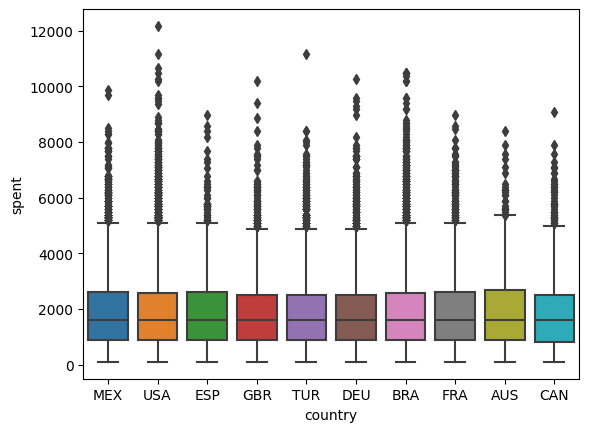

In [142]:
# Gasto por País
sns.boxplot(x=df2['country'], y=df2['spent'])


## 2.2 Gastos por Gênero

<Axes: xlabel='gender', ylabel='spent'>

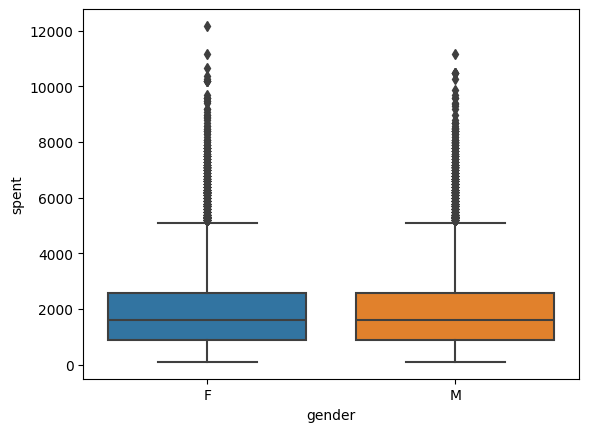

In [143]:
# Gasto por Gênero
sns.boxplot(x=df2['gender'], y=df2['spent'])


## 2.3 Gastos por Device

<Axes: xlabel='device', ylabel='spent'>

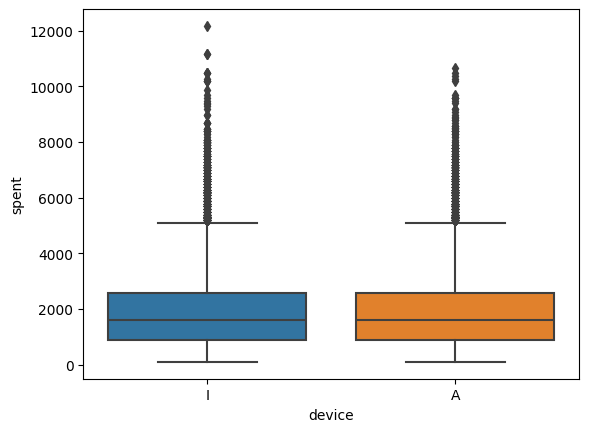

In [144]:
# Gasto por Device
sns.boxplot(x=df2['device'], y=df2['spent'])


## 2.4 Gastos por Dia

<Axes: xlabel='date', ylabel='spent'>

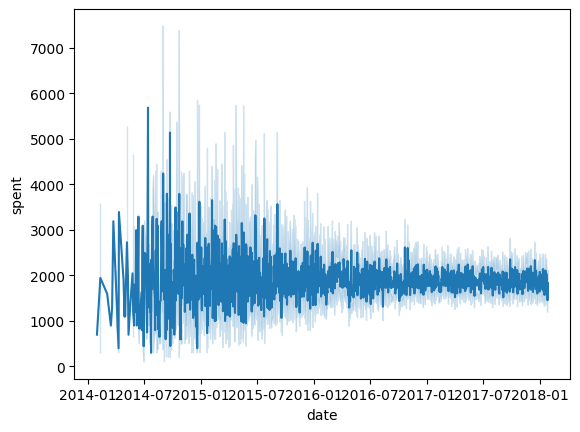

In [145]:
# Gastos por dia
sns.lineplot(x='date', y='spent', data=df2)

## 2.5 Gastos por Dia por Grupos

<Axes: xlabel='date', ylabel='spent'>

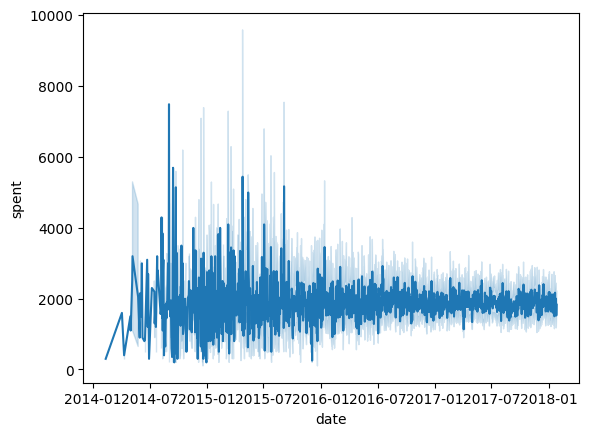

In [146]:
# Gastos por dia da página nova
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP A'])

<Axes: xlabel='date', ylabel='spent'>

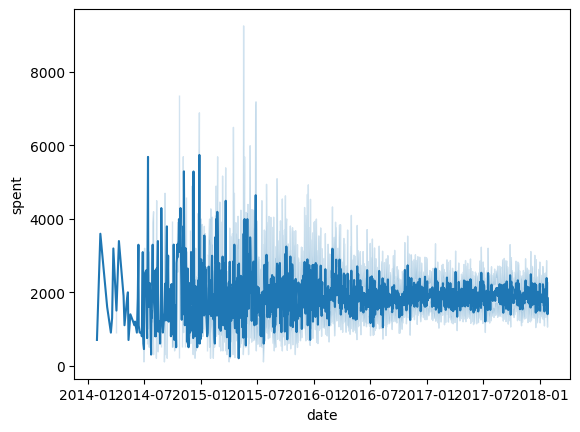

In [147]:
# Gastos por dia da página atual
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP B'])

## 2.6 Gastos por Grupos

<Axes: xlabel='group', ylabel='spent'>

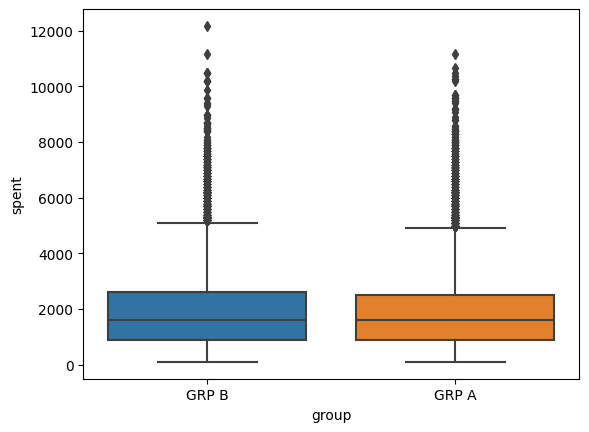

In [148]:
sns.boxplot(x=df2['group'], y=df2['spent'])

# 3.0 Design do Experimento

In [149]:
df3 = df2.copy()

## 3.1 Conferir Flags

In [150]:
df3[['uid','group']].groupby('uid').count().query('group > 1')

,group
uid,


## 3.2 Determinando dentro da Amostra

In [163]:
conversao_new = df3['spent'][df3['group'] == 'GRP A'].mean()
conversao_current = df3['spent'][df3['group'] == 'GRP B'].mean()


print('Conversão Média da Página Atual: {}'.format(conversao_current))
print('Conversão Média da Página Nova: {}'.format(conversao_new))

Conversão Média da Página Atual: 1886.4198216315467
Conversão Média da Página Nova: 1880.5042809335478


In [168]:
nivel_confianca = 0.95
nivel_significancia = 0.05

effect_size = compute_effsize(df3['spent'][df3['group'] == 'GRP A'], df3['spent'][df3['group'] == 'GRP B'], eftype='cohen')
power = 0.8

sample_n = math.ceil(sms.NormalIndPower().solve_power(
        effect_size,
        power=power,
        alpha=nivel_significancia

    ))

sample_n

834515

- Mesmo com diversas combinações, o tamanho da amostra necessária para verificar algum efeito é maior do que os dados disponíveis